# TSP: Traveling Salesman Problem

### Descripción del problema

El Problema del Vendedor Viajero (TSP, por sus siglas en inglés) es un clásico problema de optimización combinatoria. La tarea consiste en encontrar la ruta más corta que permite a un viajante visitar un conjunto de ciudades, exactamente una vez, y regresar a la ciudad de origen.

__Características del TSP:__

* Entradas: Un conjunto de ciudades y las distancias (o costos) entre cada par de ciudades.
* Objetivo: Minimizar la distancia total recorrida o el costo total del viaje.
* Restricciones: Cada ciudad debe ser visitada exactamente una vez, y el viaje debe comenzar y terminar en la misma ciudad.

__Dificultad:__
El TSP es un problema NP-hard, lo que significa que no se conoce un algoritmo que pueda resolverlo en un tiempo razonable para todos los casos a medida que el número de ciudades aumenta. Por esta razón, se han desarrollado diversas aproximaciones y heurísticas, como algoritmos genéticos, algoritmos de colonia de hormigas y métodos de optimización de enjambre.

__Aplicaciones:__
El TSP tiene aplicaciones en logística, planificación de rutas, fabricación y diseño de circuitos, entre otros campos.

In [70]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
### Se utilizará un dataset artificial que consta de 11 ciudades y su ubicación en un plano cartseiano X,Y.
### Con la ubicación se calcula la distancia euclidiana

In [72]:
data = pd.read_csv('tsp_instance.csv', sep = ';')

In [73]:
data

,ciudad,x,y
0,a,2,5
1,b,10,3
2,c,6,6
3,d,3,8
4,e,7,1
5,f,14,6
6,g,5,4
7,h,9,9
8,i,7,11
9,j,12,1


In [74]:
# ciudades a las que se debe visitar
cities = list(data["ciudad"])

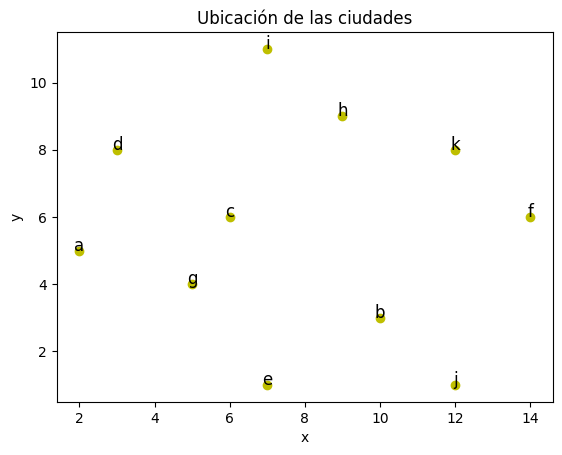

In [75]:
fig, ax = plt.subplots()
plt.title("Ubicación de las ciudades")
ax.plot(data["x"], data["y"], 'yo') 
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(data)):
    ax.text(data["x"][i], data["y"][i], data['ciudad'][i], fontsize=12, ha='center')

### Cálculo de la distancia euclidiana

In [76]:
# distancia a la ciudad j desde la ciudad i, notar que Cij == Cji (TSP simétrico)
distances = {}
for i in cities:
    for j in cities:
        if i!=j:
            x1 = data.loc[data["ciudad"] == i, "x"].values[0]
            y1 = data.loc[data["ciudad"] == i, "y"].values[0]
            x2 = data.loc[data["ciudad"] == j, "x"].values[0]
            y2 = data.loc[data["ciudad"] == j, "y"].values[0]
            distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) 
        else:
            distance = 0
        distances[(i,j)] = distance
        distances[(j,i)] = distance

### Formulación del problema de optimización

In [77]:
def get_problem(costos, n ):
    # instanciar el problema
    problem = pulp.LpProblem("Minimizar_Costos_TSP", pulp.LpMinimize)

    # definición de variables

    # 1 Si se va desde la ciudad i a la ciudad j, 0 si no
    X = pulp.LpVariable.dicts("X", ((i, j) for i in cities for j in cities if i!= j), lowBound=0, cat='Integer')

    # contador de las ciudades visitas (MTZ)
    U = pulp.LpVariable.dicts("U", (i for i in cities), lowBound=0, cat='Continuos')
    
    # definición de la función objetivo: minimizar los costos
    problem += pulp.lpSum(costos[(i,j)] * X[(i,j)] for i in cities for j in cities if i!=j)

    # definicón de las restricciones

    # solo se sale una vez de la ciudad i
    for i in cities:
        problem += pulp.lpSum(X[(i,j)] for j in cities if i!=j) == 1

    # solo se llega una vez de la ciudad j
    for j in cities:
        problem += pulp.lpSum(X[(i,j)] for i in cities if i!=j) == 1

    # eliminación de subtours MTZ
    for i in cities[1:]:
        for j in cities:
            if i!=j:
                problem += U[i] - U[j] + 1 <= (n-1) * (1-X[(i,j)])
                
    for i in cities[1:]:
        2 <= U[i]
        U[i] <= n
        
    return problem, X

### Solución del problema

In [78]:
problema, x = get_problem(distances, len(cities))

In [79]:
problema.solve(pulp.PULP_CBC_CMD(msg=True))

1

#### Distancia Optima

In [80]:
# Imprimir resultados
print(f"Estado: {pulp.LpStatus[problema.status]}")
print(f"Distancia óptima a recorrer por el vendedor: {pulp.value(problema.objective)} unidades de longitud")

Estado: Optimal
Distancia óptima a recorrer por el vendedor: 38.76527765575526 unidades de longitud


### Ruta Optima

In [81]:
ruta = ["a"] # primera ciudad
cont = 0
while len(ruta) < len(cities): # si el largo de la ruta no es la cantidad de ciudades sigo bsucando las siguientes ciudades
    for j in cities:
        if cities[cont]!= j:
            # busco los arcos i - j que si forman parte de la ruta optima, con valor == 1
            # con cont y ruta, se cuál es la ultima ciudad recorrida y desde ahí comienzo a buscar cual es la siguiente
            if  0 < x[(ruta[cont], j)].varValue:
                ruta.append(j)
                cont +=1
                if len(ruta) == len(cities):
                    break;

In [82]:
for i in cities:
    for j in cities:
        if i!=j:
            if 0 < x[(i, j)].varValue :
                print(f"Camino optimo: desde la ciudad  {i} a la ciudad  {j}")

Camino optimo: desde la ciudad  a a la ciudad  d
Camino optimo: desde la ciudad  b a la ciudad  e
Camino optimo: desde la ciudad  c a la ciudad  a
Camino optimo: desde la ciudad  d a la ciudad  i
Camino optimo: desde la ciudad  e a la ciudad  g
Camino optimo: desde la ciudad  f a la ciudad  j
Camino optimo: desde la ciudad  g a la ciudad  c
Camino optimo: desde la ciudad  h a la ciudad  k
Camino optimo: desde la ciudad  i a la ciudad  h
Camino optimo: desde la ciudad  j a la ciudad  b
Camino optimo: desde la ciudad  k a la ciudad  f


In [83]:
print(f"La ruta optima corresponde a recorrer las ciudades en el siguiente orden: {','.join(ruta)}")

La ruta optima corresponde a recorrer las ciudades en el siguiente orden: a,d,i,h,k,f,j,b,e,g,c


In [84]:
orden = pd.DataFrame({"ciudad":ruta,"orden": [i for i in range(len(ruta))]})

In [85]:
data = data.merge(orden, how = 'inner', on = 'ciudad')
data = data.sort_values(by = 'orden')

### Visualización Ruta Optima

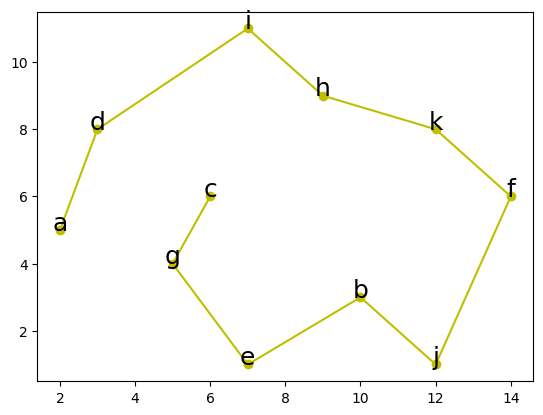

In [86]:
fig, ax = plt.subplots()

ax.plot(data["x"], data["y"], 'y-o')  # 'ko' para puntos negros
# Añadir etiquetas
for i in range(len(data)):
    ax.text(data["x"][i], data["y"][i], data['ciudad'][i], fontsize=18, ha='center')

__Nota__: Al terminar de visitar la ultima ciudad retorna al punto inicial a.

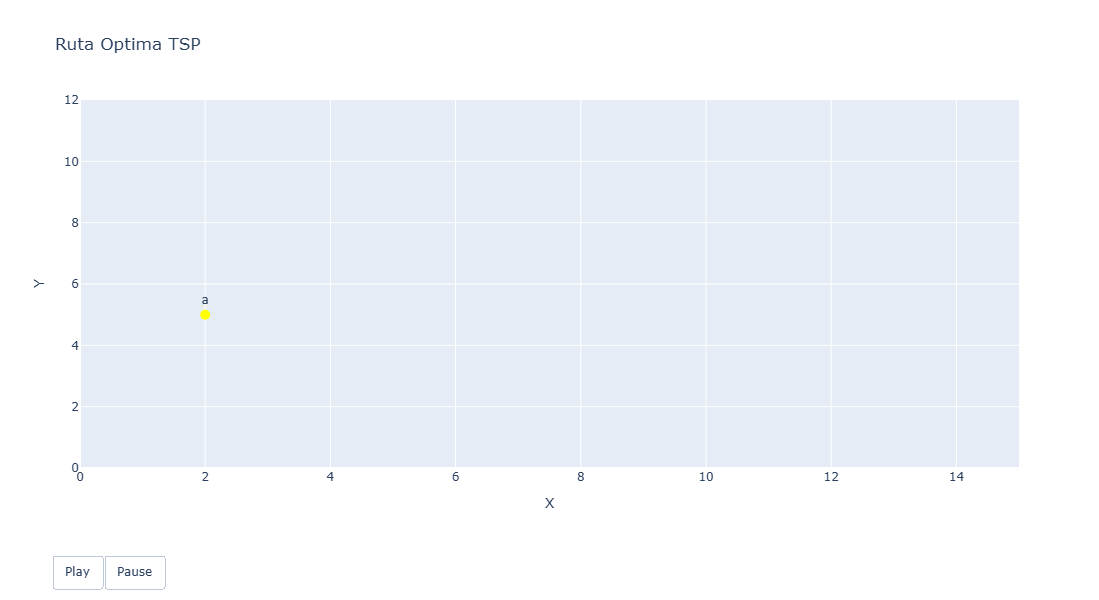

In [89]:
import plotly.graph_objects as go
import pandas as pd

# Crear una figura
fig = go.Figure()

# Crear los frames para la animación
frames = []
for i in range(len(data)):
    frame_data = go.Scatter(
        x=data["x"][:i+1],
        y=data["y"][:i+1],
        mode='markers+lines+text',
        text=data['ciudad'][:i+1],
        textposition='top center',
        marker=dict(size=10, color='yellow')
    )
    frames.append(go.Frame(data=[frame_data]))

# Agregar la traza inicial (sin animación)
fig.add_trace(frames[0].data[0])

# Configurar el layout
fig.update_layout(
    title='Ruta Optima TSP',
    xaxis_title='X',
    yaxis_title='Y',
    showlegend=False,
    width=600,
    height=600,
    xaxis=dict(range=[0, 15]),  # Define los límites del eje x
    yaxis=dict(range=[0, 12]),  # Define los límites del eje y
    updatemenus=[{
        'buttons': [
            {
                'label': 'Play',
                'method': 'animate',
                'args': [None, {
                    'frame': {'duration': 500, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            },
            {
                'label': 'Pause',
                'method': 'animate',
                'args': [[None], {
                    'frame': {'duration': 0, 'redraw': True},
                    'mode': 'immediate',
                    'transition': {'duration': 0}
                }]
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
)

# Asignar los frames a la figura
fig.frames = frames
fig.write_html("grafico_animado.html")
# Mostrar la figura
fig.show()
